<a href="https://colab.research.google.com/github/ayagit1/Fashion-Classification-By-Gender/blob/main/Fashion_image_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Fashion Product Images Neural Network for Gender Multiclassification**

This code is for a fashion image classification project using deep learning, specifically convolutional neural networks (CNNs), to classify fashion products based on their images and other features. This is the Dataset : https://www.kaggle.com/datasets/paramaggarwal/fashion-product-images-dataset/data

This project focuses on gender classification using a fashion dataset containing images and metadata. The data is cleaned, and missing values are handled before conducting exploratory data analysis to understand gender distribution, product categories, and trends. Images are resized, normalized, and paired with one-hot encoded gender labels. A Convolutional Neural Network (CNN) is used for classification, featuring convolutional, pooling, and dense layers. The model is trained and evaluated using metrics like precision, recall, and F1-score, with misclassifications visualized to identify areas for improvement. This approach effectively predicts gender based on fashion images.

- **Key Insights:**
- Data Processing: The code handles the fashion data and images, processes them, and ensures that the images are of consistent size and normalized.
- CNN Model: A deep learning model is constructed and trained for fashion classification based on images, using CNN layers to learn spatial hierarchies in the images.
- Performance Monitoring: The code tracks the model's progress during training and evaluates it on the test set, using metrics like accuracy and loss, with some additional steps for model validation (confusion matrix, precision, recall, etc.).

# Data Loading

In [150]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
paramaggarwal_fashion_product_images_small_path = kagglehub.dataset_download('paramaggarwal/fashion-product-images-small')

print('Data source import complete.')


Data source import complete.


In [151]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import pickle
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import time
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout, Input, Flatten
from keras.layers import Conv2D, MaxPooling2D
import numpy as np
from keras.models import load_model

In [152]:
STYLES_CSV_PATH = "/root/.cache/kagglehub/datasets/paramaggarwal/fashion-product-images-small/versions/1/styles.csv"

IMAGES_PATH = "/root/.cache/kagglehub/datasets/paramaggarwal/fashion-product-images-small/versions/1/images/"

In [153]:
# Read the CSV file using the corrected path
data = pd.read_csv(STYLES_CSV_PATH, on_bad_lines='skip',
                   usecols=['id', 'gender', 'masterCategory', 'baseColour', 'season', 'usage'])

data = data.dropna()

# Correct path to the downloaded images directory
image_path = IMAGES_PATH

# EDA

In [154]:
data.keys()

Index(['id', 'gender', 'masterCategory', 'baseColour', 'season', 'usage'], dtype='object')

In [155]:
data['gender'].unique(),data['season'].unique(), data['usage'].unique()


(array(['Men', 'Women', 'Boys', 'Girls', 'Unisex'], dtype=object),
 array(['Fall', 'Summer', 'Winter', 'Spring'], dtype=object),
 array(['Casual', 'Ethnic', 'Formal', 'Sports', 'Smart Casual', 'Travel',
        'Party', 'Home'], dtype=object))

In [156]:
data

,id,gender,masterCategory,baseColour,season,usage
0,15970,Men,Apparel,Navy Blue,Fall,Casual
1,39386,Men,Apparel,Blue,Summer,Casual
2,59263,Women,Accessories,Silver,Winter,Casual
3,21379,Men,Apparel,Black,Fall,Casual
4,53759,Men,Apparel,Grey,Summer,Casual
...,...,...,...,...,...,...
44441,17036,Men,Footwear,White,Summer,Casual
44442,6461,Men,Footwear,Red,Summer,Casual
44443,18842,Men,Apparel,Blue,Fall,Casual
44444,46694,Women,Personal Care,Blue,Spring,Casual


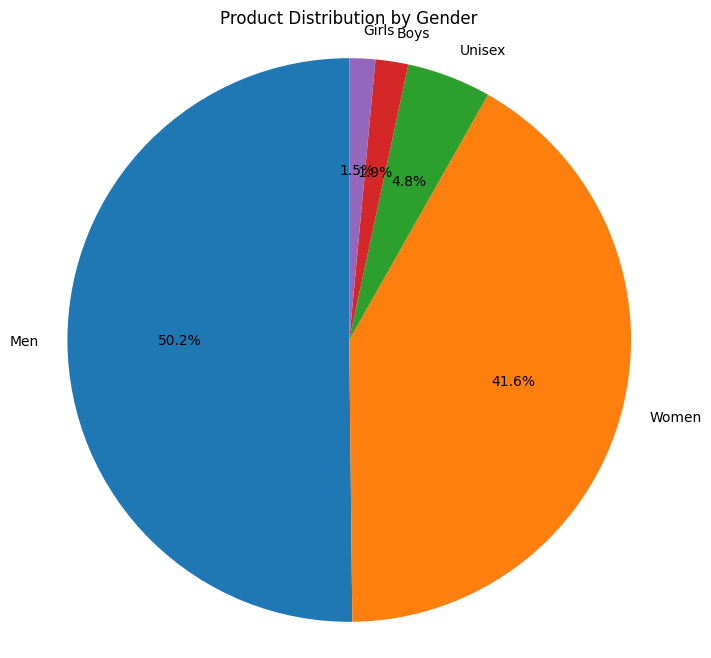

In [157]:
# @title Product Distribution by Gender

import matplotlib.pyplot as plt

# Assuming 'data' is your DataFrame
gender_counts = data['gender'].value_counts()

plt.figure(figsize=(8, 8))
plt.pie(gender_counts.values, labels=gender_counts.index, autopct='%1.1f%%', startangle=90)
plt.title('Product Distribution by Gender')
_ = plt.axis('equal')

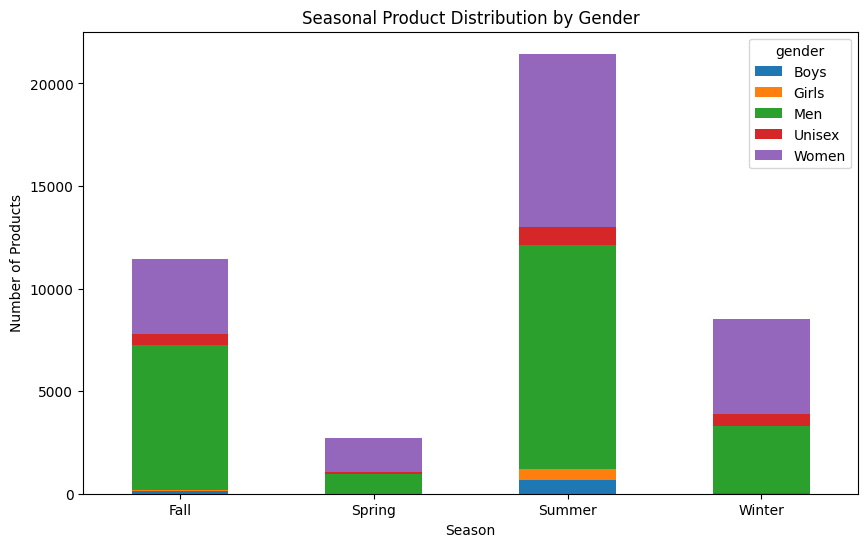

In [158]:
# @title Seasonal Product Distribution by Gender

import matplotlib.pyplot as plt
import pandas as pd

# Assuming 'data' is your DataFrame

season_gender_counts = data.groupby(['season', 'gender'])['id'].count().unstack()

season_gender_counts.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.xlabel('Season')
plt.ylabel('Number of Products')
plt.title('Seasonal Product Distribution by Gender')
_ = plt.xticks(rotation=0)

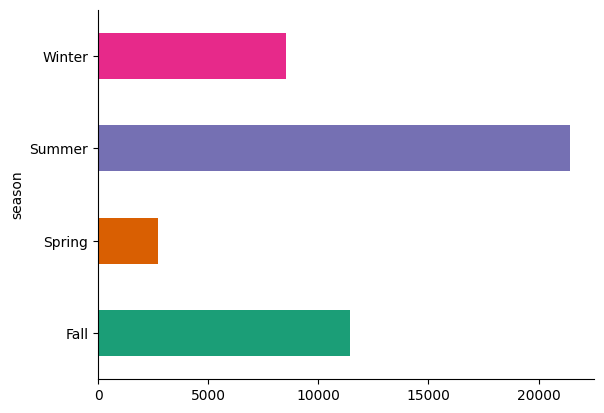

In [159]:
# @title season

from matplotlib import pyplot as plt
import seaborn as sns
data.groupby('season').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

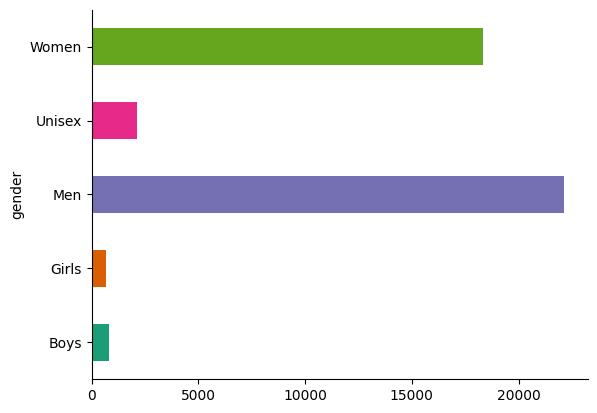

In [160]:
# @title gender

from matplotlib import pyplot as plt
import seaborn as sns
data.groupby('gender').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

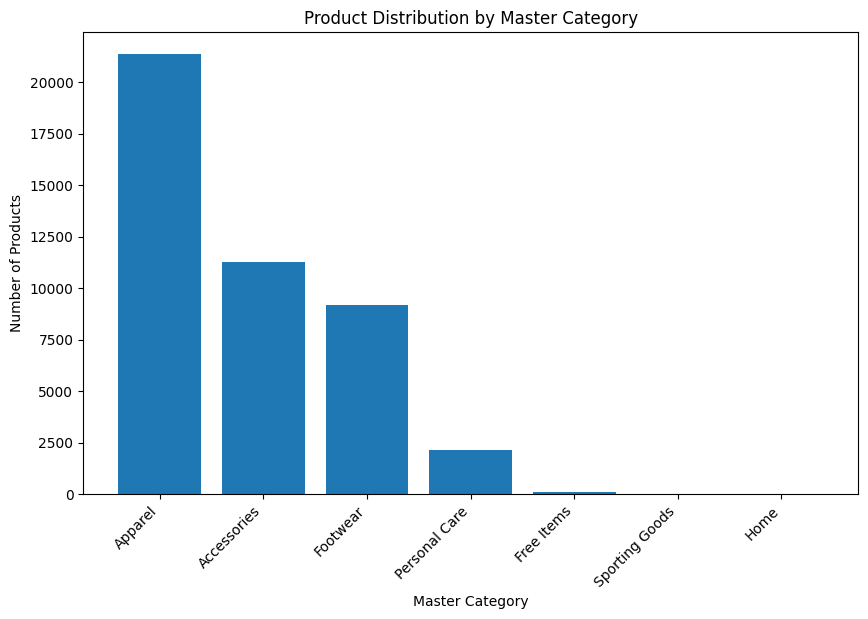

In [161]:
# @title Product Distribution by Master Category

import matplotlib.pyplot as plt

# Assuming 'data' is your DataFrame
master_category_counts = data['masterCategory'].value_counts()

plt.figure(figsize=(10, 6))
plt.bar(master_category_counts.index, master_category_counts.values)
plt.xlabel('Master Category')
plt.ylabel('Number of Products')
plt.title('Product Distribution by Master Category')
_ = plt.xticks(rotation=45, ha='right')

In [162]:
# Display missing values for each column
missing_values = data.isna().sum()

# Print missing values
print("Missing values in the dataset:")
print(missing_values)

# Optional: Highlight columns with missing values
columns_with_missing = missing_values[missing_values > 0]
if not columns_with_missing.empty:
    print("\nColumns with missing values:")
    print(columns_with_missing)
else:
    print("\nNo missing values detected in the dataset.")

Missing values in the dataset:
id                0
gender            0
masterCategory    0
baseColour        0
season            0
usage             0
dtype: int64

No missing values detected in the dataset.


In [163]:
def plot_head_5_image(col):
    for category in data[col].unique():
        fig, axs = plt.subplots(1, 5, figsize = (15, 10))
        for i, ax in zip(data[data[col] == category]['id'][:5], axs.ravel()):
            jpg_path = f'{image_path}/{str(i)}.jpg'
            images = plt.imread(jpg_path)
            ax.imshow(images, cmap = 'gray')
            ax.set_title(f'{category}:{i}')
    plt.show()

In [164]:
use_cols = ['gender', 'season', 'usage', 'masterCategory', 'baseColour']

gender


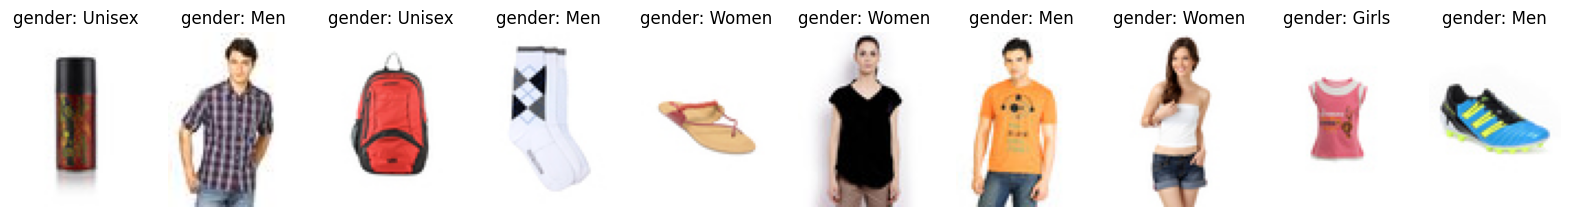

masterCategory


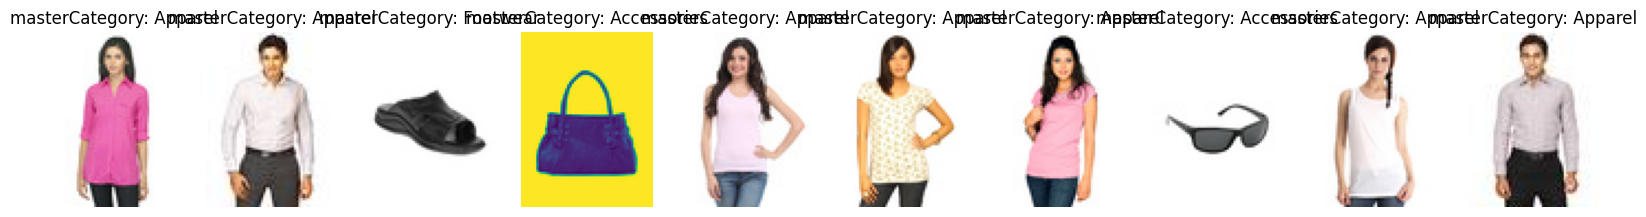

baseColour


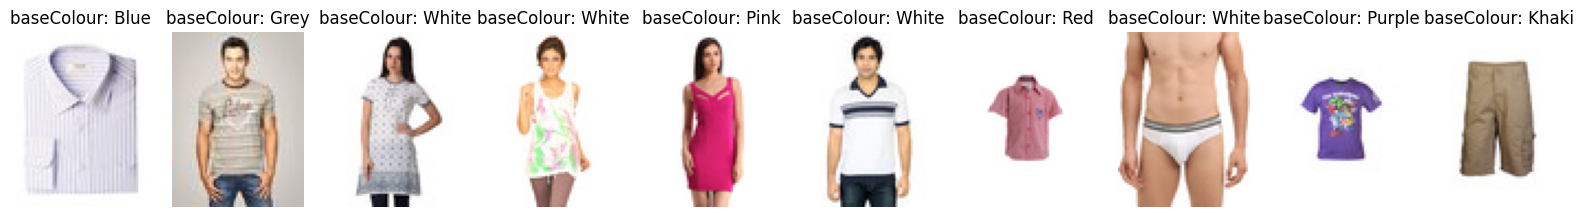

season


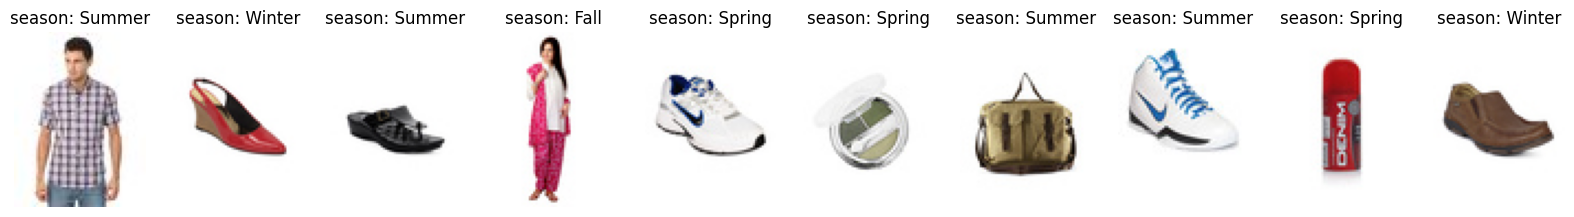

In [165]:
# Define the function show_k_random
def show_k_random(k, col):
  """
  Displays k random images from the dataset with the specified attribute.

  Args:
    k: The number of random images to display.
    col: The name of the attribute to filter images by (e.g., 'gender').
  """
  sample = data.sample(k)
  fig, axes = plt.subplots(1, k, figsize=(20, 20))
  for i, (_, row) in enumerate(sample.iterrows()):
    image_file = os.path.join(image_path, f"{row['id']}.jpg")
    if os.path.exists(image_file):
      image = plt.imread(image_file)
      axes[i].imshow(image)
      axes[i].set_title(f"{col}: {row[col]}")
      axes[i].axis('off')
  plt.show()

# Now call the function for each label
labels = data.columns[1:-1]  # Assuming the first and last columns are not labels
for col in labels:
    print(col)
    show_k_random(10, col)

In [168]:
data.head()

,id,gender,masterCategory,baseColour,season,usage
0,15970,Men,Apparel,Navy Blue,Fall,Casual
1,39386,Men,Apparel,Blue,Summer,Casual
2,59263,Women,Accessories,Silver,Winter,Casual
3,21379,Men,Apparel,Black,Fall,Casual
4,53759,Men,Apparel,Grey,Summer,Casual


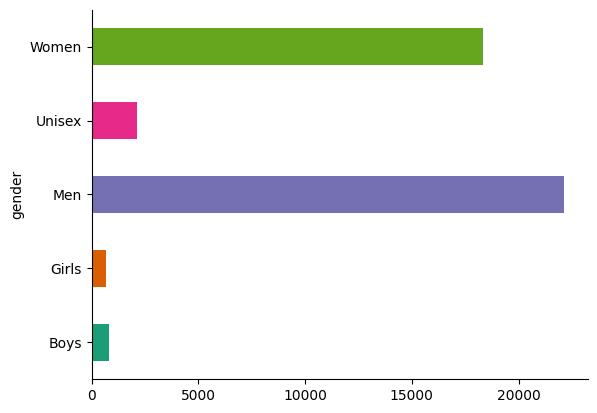

In [17]:
# @title gender

from matplotlib import pyplot as plt
import seaborn as sns
data.groupby('gender').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

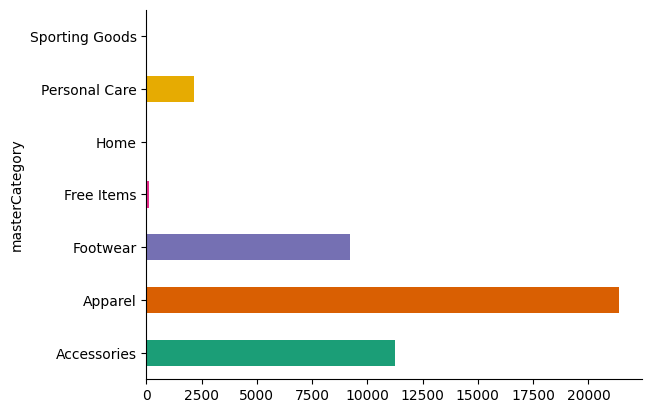

In [16]:
# @title masterCategory

from matplotlib import pyplot as plt
import seaborn as sns
data.groupby('masterCategory').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

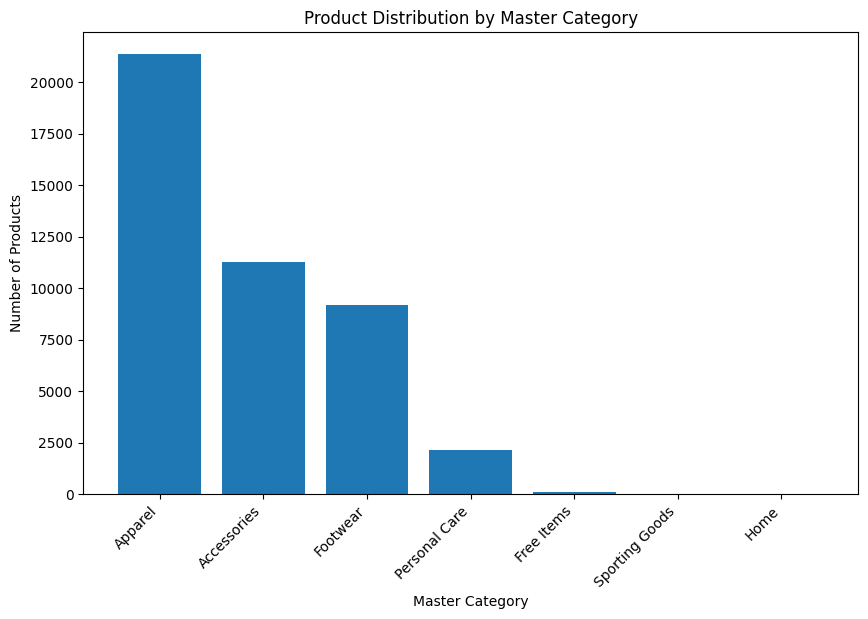

In [15]:
# @title Product Distribution by Master Category

import matplotlib.pyplot as plt
import pandas as pd

# Assuming 'data' is your DataFrame
master_category_counts = data['masterCategory'].value_counts()

plt.figure(figsize=(10, 6))
plt.bar(master_category_counts.index, master_category_counts.values)
plt.xlabel('Master Category')
plt.ylabel('Number of Products')
plt.title('Product Distribution by Master Category')
_ = plt.xticks(rotation=45, ha='right')

# Image Processing

In [40]:
def img_to_array(path, filter_col, data):
    img_array = []
    img_label_counts = []

    # Filter data to the necessary column (gender in this case)
    filter_data = data[['id', filter_col]]

    # Define the new classes manually
    filter_name = ['Men', 'Women', 'Boys', 'Girls', 'Unisex']

    # Map each class to a unique index for one-hot encoding
    filter_label = {name: i for i, name in enumerate(filter_name)}  # Updated for the new classes

    for i, key in enumerate(filter_label):
        print(i, key)

        # Process up to 1000 images of each class (you can change the number if needed)
        for file in filter_data[filter_data[filter_col] == key]['id'][:1000]:
            if str(file) + '.jpg' not in os.listdir(path):
                print(f'{file}non-existent')  # Print missing images
            else:
                jpg_path = f'{path}/{str(file)}.jpg'
                images = plt.imread(jpg_path)

                if images.shape != (80, 60, 3):  # Ensure the image size matches the expected dimensions
                    pass
                else:
                    # Normalize the image (values between 0 and 1)
                    img_array.append(images.astype('float32') / 255)

                    # Create one-hot encoded labels for the gender
                    label_zero = np.zeros(len(filter_label))
                    label_zero[i] = 1
                    img_label_counts.append(label_zero)

    return img_array, img_label_counts , filter_label


In [39]:
gender_array, gender_label_counts, gender_label = img_to_array(image_path, 'gender', data)
gender_np = np.array(gender_array)
gender_label_np = np.array(gender_label_counts)

0 Men
1 Women
2 Boys
3 Girls
4 Unisex


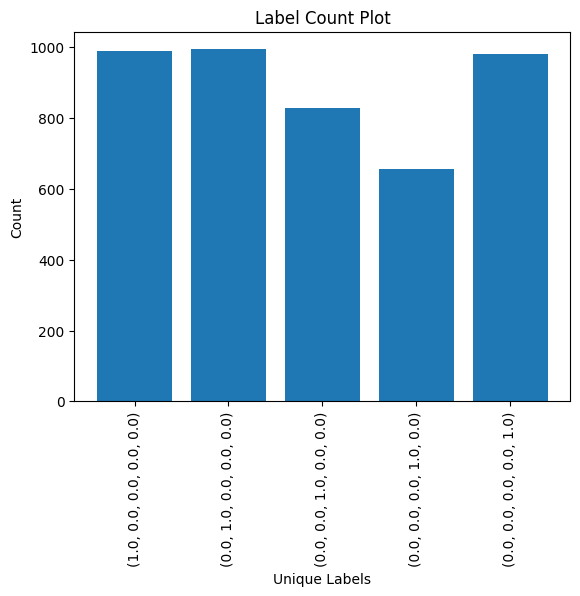

In [41]:
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

def label_count_plot(label):
    # Convert list of arrays to a 2D numpy array
    label_array = np.array(label)

    # Convert each row to a tuple to make it hashable, then count occurrences
    label_tuples = [tuple(row) for row in label_array]
    label_counts = Counter(label_tuples)

    # Get unique labels and their counts
    unique_labels = list(label_counts.keys())
    value_counts = list(label_counts.values())

    # Plotting the counts
    plt.bar(range(len(unique_labels)), value_counts)
    plt.xticks(range(len(unique_labels)), [str(label) for label in unique_labels], rotation=90)  # Set x-axis labels
    plt.xlabel("Unique Labels")
    plt.ylabel("Count")
    plt.title("Label Count Plot")
    plt.show()

# Example usage
label_count_plot(gender_label_counts)


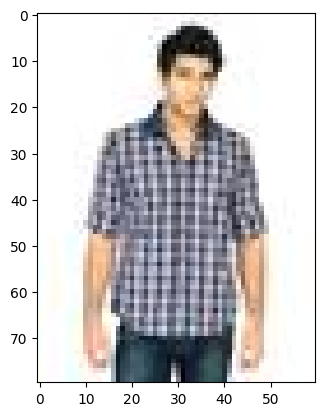

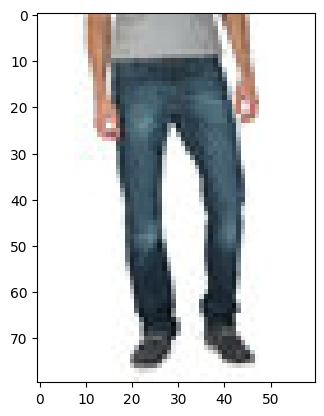

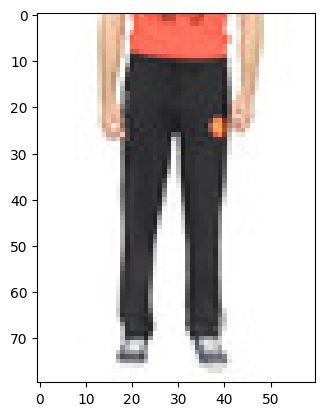

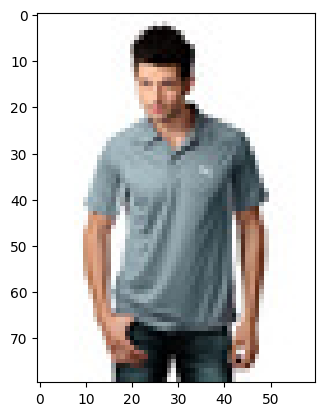

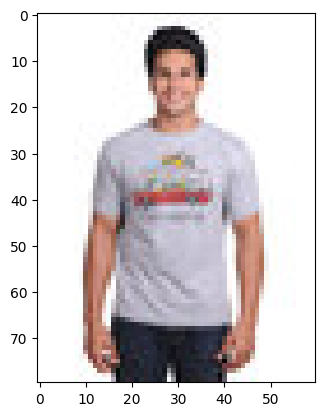

In [42]:
def plot_img(array):
    for i in array:
        plt.imshow(i, cmap = 'gray')
        plt.show()
plot_img(gender_array[:5])

# Model

In [52]:
x_train, x_test, y_train, y_test = train_test_split(gender_np, gender_label_np)
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

model = Sequential()
model.add(Conv2D(32, kernel_size = (5, 5), activation='relu', input_shape=(80, 60, 3)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(2, 2))
model.add(Dropout(0.25))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(MaxPooling2D(2, 2))
model.add(Conv2D(32, kernel_size = (3, 3), activation='relu'))
model.add(Flatten())
model.add(Dense((5), activation = 'softmax'))
model.summary()
model.compile(optimizer ='adam', loss ='categorical_crossentropy', metrics = ['accuracy'])
history = model.fit(x_train, y_train, epochs = 15, batch_size = 54)
model.save('gender.h5')

(3336, 80, 60, 3) (3336, 5) (1112, 80, 60, 3) (1112, 5)


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_17 (Conv2D)                   │ (None, 76, 56, 32)          │           2,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_18 (Conv2D)                   │ (None, 74, 54, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 37, 27, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_12 (Dropout)                 │ (None, 37, 27, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 37, 27, 128)         │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_13 (Dropout)                 │ (None, 37, 27, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_12 (MaxPooling2D)      │ (None, 18, 13, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_19 (Conv2D)                   │ (None, 16, 11, 32)          │          36,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_6 (Flatten)                  │ (None, 5632)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 5)                   │          28,165 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 94,309 (368.39 KB)

 Trainable params: 94,309 (368.39 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
105/105 ━━━━━━━━━━━━━━━━━━━━ 76s 704ms/step - accuracy: 0.3263 - loss: 1.5066
Epoch 2/15
105/105 ━━━━━━━━━━━━━━━━━━━━ 79s 674ms/step - accuracy: 0.6007 - loss: 1.0275
Epoch 3/15
105/105 ━━━━━━━━━━━━━━━━━━━━ 71s 678ms/step - accuracy: 0.6548 - loss: 0.9170
Epoch 4/15
105/105 ━━━━━━━━━━━━━━━━━━━━ 80s 657ms/step - accuracy: 0.6969 - loss: 0.7949
Epoch 5/15
105/105 ━━━━━━━━━━━━━━━━━━━━ 82s 661ms/step - accuracy: 0.7189 - loss: 0.7404
Epoch 6/15
105/105 ━━━━━━━━━━━━━━━━━━━━ 83s 676ms/step - accuracy: 0.7587 - loss: 0.6499
Epoch 7/15
105/105 ━━━━━━━━━━━━━━━━━━━━ 81s 668ms/step - accuracy: 0.7966 - loss: 0.5655
Epoch 8/15
105/105 ━━━━━━━━━━━━━━━━━━━━ 82s 669ms/step - accuracy: 0.8004 - loss: 0.5292
Epoch 9/15
105/105 ━━━━━━━━━━━━━━━━━━━━ 69s 656ms/step - accuracy: 0.8402 - loss: 0.4255
Epoch 10/15
105/105 ━━━━━━━━━━━━━━━━━━━━ 84s 676ms/step - accuracy: 0.8550 - loss: 0.4132
Epoch 11/15
105/105 ━━━━━━━━━━━━━━━━━━━━ 71s 674ms/step - accuracy: 0.8712 - loss: 0.3506
Epoch 12/15
105/105

It looks like the model training has significantly improved over the epochs, with both accuracy and loss showing good progress. By Epoch 15, the accuracy reached 91.45%, and the loss decreased to 0.2311, indicating that the model is learning well.

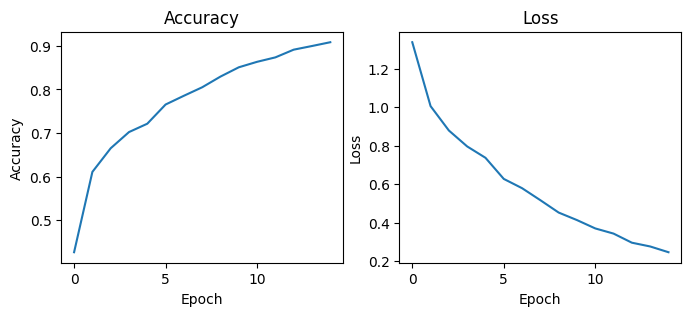

In [53]:
fig, ax = plt.subplots(1, 2, figsize = (8, 3))
ax[0].plot(history.history['accuracy'], label='accuracy')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Accuracy')
ax[0].set_title('Accuracy')
ax[1].plot(history.history['loss'], label='Loss')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
ax[1].set_title('Loss')
plt.show()

In [58]:
preds = model.predict(x_test[:9])
print('The first 9 predictions:\n',)
for real, pred in zip(y_test[:9], np.argmax(preds, axis=-1)):
    print('Predict:', pred)
    print(f'Real: {np.where(real == 1)}')
print('The first 9 actual values:\n', y_test.reshape(-1,).astype('int32'))
gender_pred = model.predict(x_test)
score = model.evaluate(x_test, y_test)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
The first 9 predictions:

Predict: 4
Real: (array([3]),)
Predict: 0
Real: (array([4]),)
Predict: 3
Real: (array([3]),)
Predict: 0
Real: (array([2]),)
Predict: 0
Real: (array([0]),)
Predict: 0
Real: (array([0]),)
Predict: 4
Real: (array([4]),)
Predict: 2
Real: (array([2]),)
Predict: 0
Real: (array([0]),)
The first 9 actual values:
 [0 0 0 ... 1 0 0]
35/35 ━━━━━━━━━━━━━━━━━━━━ 5s 135ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 190ms/step - accuracy: 0.7463 - loss: 0.7585
Test loss: 0.787169873714447
Test accuracy: 0.7401078939437866


In [57]:
preds = model.predict(x_test[:9])
for real, pred in zip(y_test[:9], np.argmax(preds, axis=-1)):
    print(f'Predicted: {pred} | Actual: {np.where(real == 1)}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
Predicted: 4 | Actual: (array([3]),)
Predicted: 0 | Actual: (array([4]),)
Predicted: 3 | Actual: (array([3]),)
Predicted: 0 | Actual: (array([2]),)
Predicted: 0 | Actual: (array([0]),)
Predicted: 0 | Actual: (array([0]),)
Predicted: 4 | Actual: (array([4]),)
Predicted: 2 | Actual: (array([2]),)
Predicted: 0 | Actual: (array([0]),)


### Confusion Matrix

precision score: 0.7401
recall score: 0.7401
f1 score: 0.7401


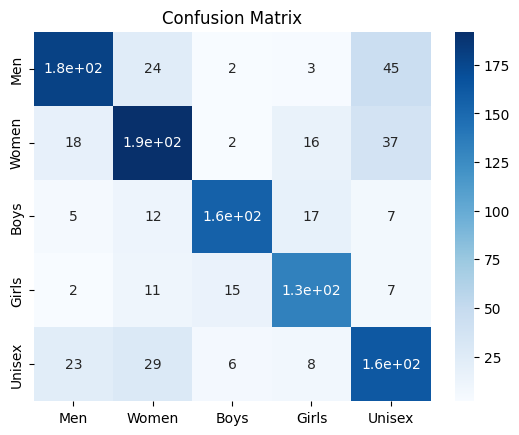

In [56]:
precision = precision_score(np.argmax(y_test, axis=-1), np.argmax(gender_pred, axis = -1), average = 'micro')
recall = recall_score(np.argmax(y_test, axis=-1), np.argmax(gender_pred, axis = -1), average = 'micro')
F1 = f1_score(np.argmax(y_test, axis=-1), np.argmax(gender_pred, axis = -1), average = 'micro')
CM = confusion_matrix(np.argmax(y_test, axis=-1), np.argmax(gender_pred, axis = -1))
print('precision score:',round(precision,4))
print('recall score:',round(recall,4))
print('f1 score:',round(F1,4))
plt.title("Confusion Matrix")
sns.heatmap(CM,annot = True,xticklabels = gender_label, yticklabels = gender_label,cmap = plt.cm.Blues)
plt.show()

# Test

- 0 Men
- 1 Women
- 2 Boys
- 3 Girls
- 4 Unisex


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


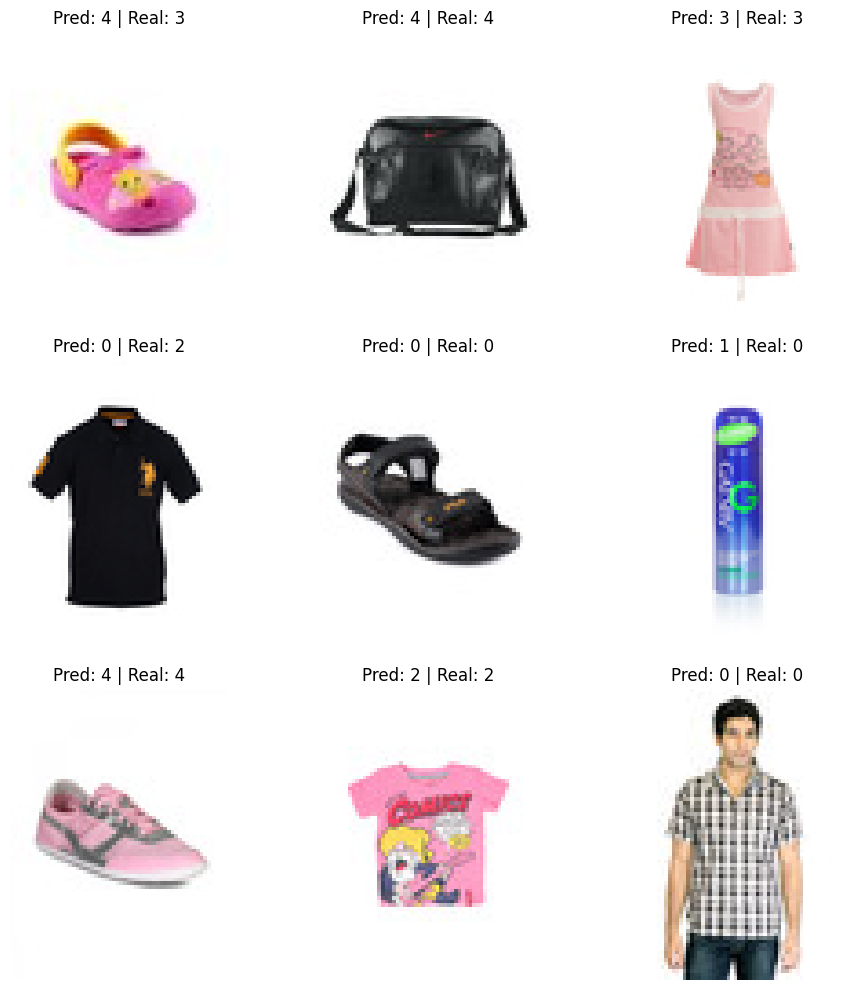

In [82]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming preds and y_test are available from previous code
preds = model.predict(x_test[:9])

# Plot images with predictions and actual values
fig, axes = plt.subplots(3, 3, figsize=(10, 10))
axes = axes.ravel()

for i in range(9):
    ax = axes[i]
    ax.imshow(x_test[i], cmap='gray')
    ax.set_title(f'Pred: {np.argmax(preds[i])} | Real: {np.where(y_test[i] == 1)[0][0]}')
    ax.axis('off')

plt.tight_layout()
plt.show()